In [1]:

import os
import sys
import random
import math

import time
import numpy as np

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import Luna

%matplotlib inline 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import tensorflow

In [3]:
tensorflow.__version__

'1.15.0'

In [4]:

# Dataset directory
DATASET_DIR = "prepared_data"

# Inference Configuration
config = Luna.LunaInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [7]:
# Load validation dataset
dataset = Luna.LunaDataset()
dataset.load_nodule(DATASET_DIR, "test")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 392
Classes: ['BG', 'nodule']


In [8]:
# Create model in inference mode
LOGS_DIR = "logs"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Path to a specific weights file
weights_path = "logs/nucleus20200529T1534/mask_rcnn_nucleus_0040.h5"

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  logs/nucleus20200529T1534/mask_rcnn_nucleus_0040.h5






Re-starting from epoch 40


158
image ID: nodule.240 (158) 240
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    1.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    1.00000  max:  251.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  608.00000  max:  860.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


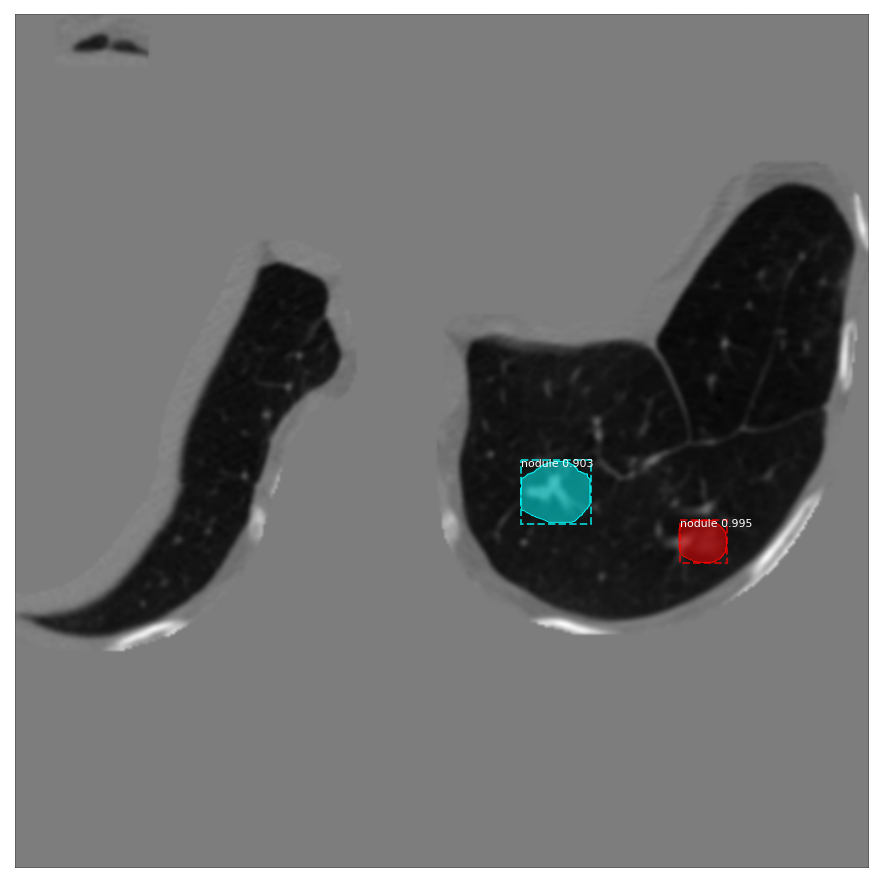

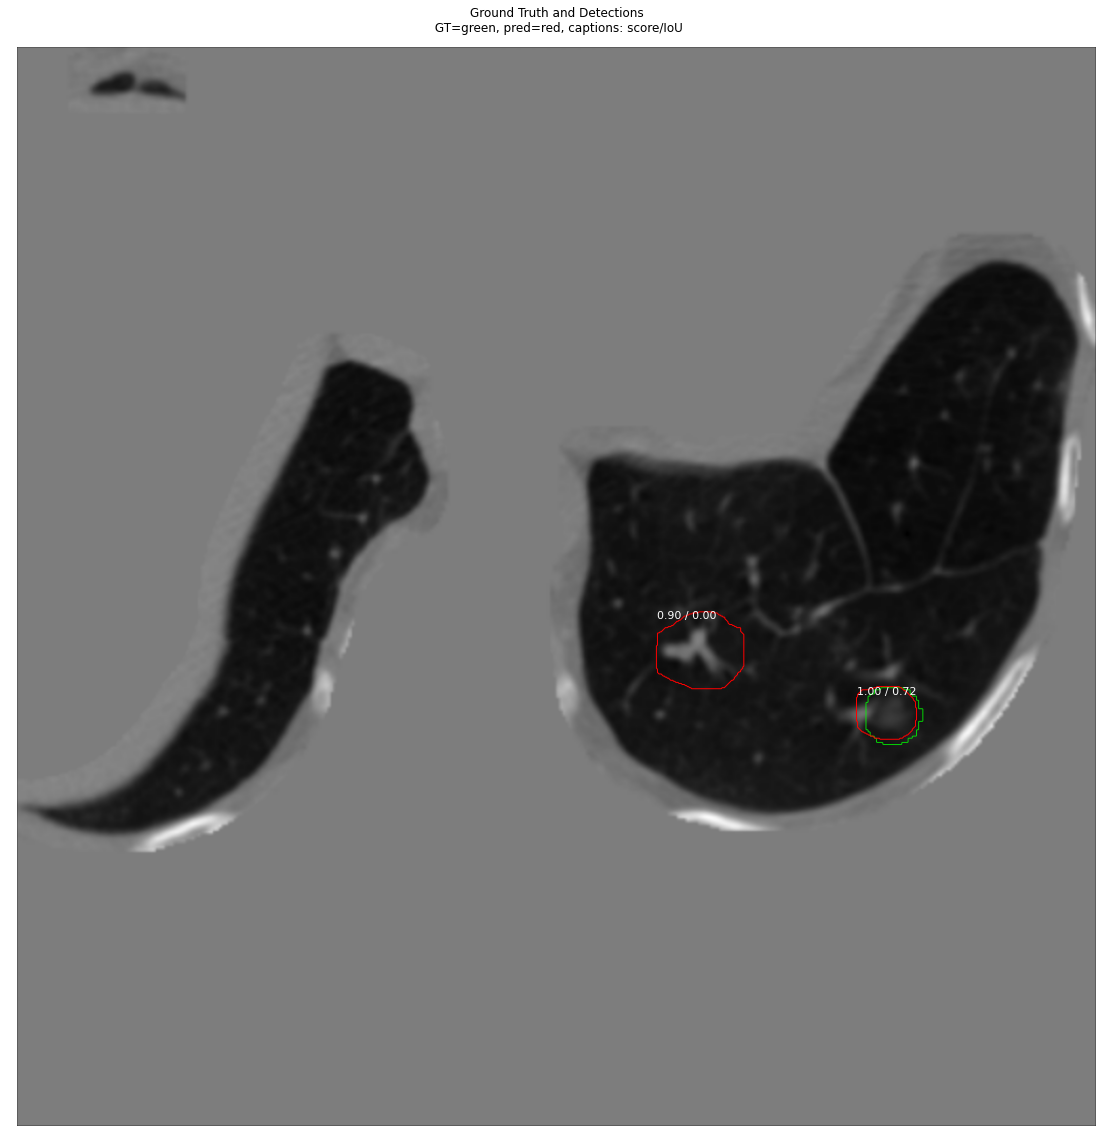

In [10]:
image_id = random.choice(dataset.image_ids)
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id,use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names,  r['scores'])

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)


In [11]:
image_ids = np.random.choice((dataset.image_ids), 10)
APs = []
presision=[]
recall=[]
overlap=[]
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id,use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    presision.append(precisions)
    recall.append(recalls)
    overlap.append(overlaps)
    
print("mAP: ", np.mean(APs))

mAP:  0.4342857142857143


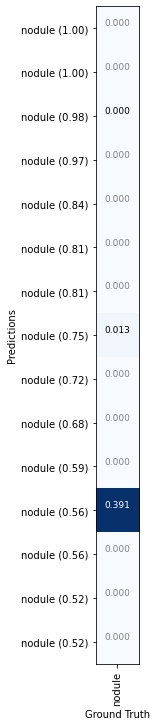

In [12]:
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)


In [14]:
recall

[array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.]),
 array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]),
 array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 1., 1., 

In [13]:
visualize.display_table(APs)

TypeError: 'numpy.float64' object is not iterable

299
image ID: nodule.368 (299) 368
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    1.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    1.00000  max:  253.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  508.00000  max:  810.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000
Shapes  (1, 4) (16, 4)
(16, 4) (16, 4)
288628.453125


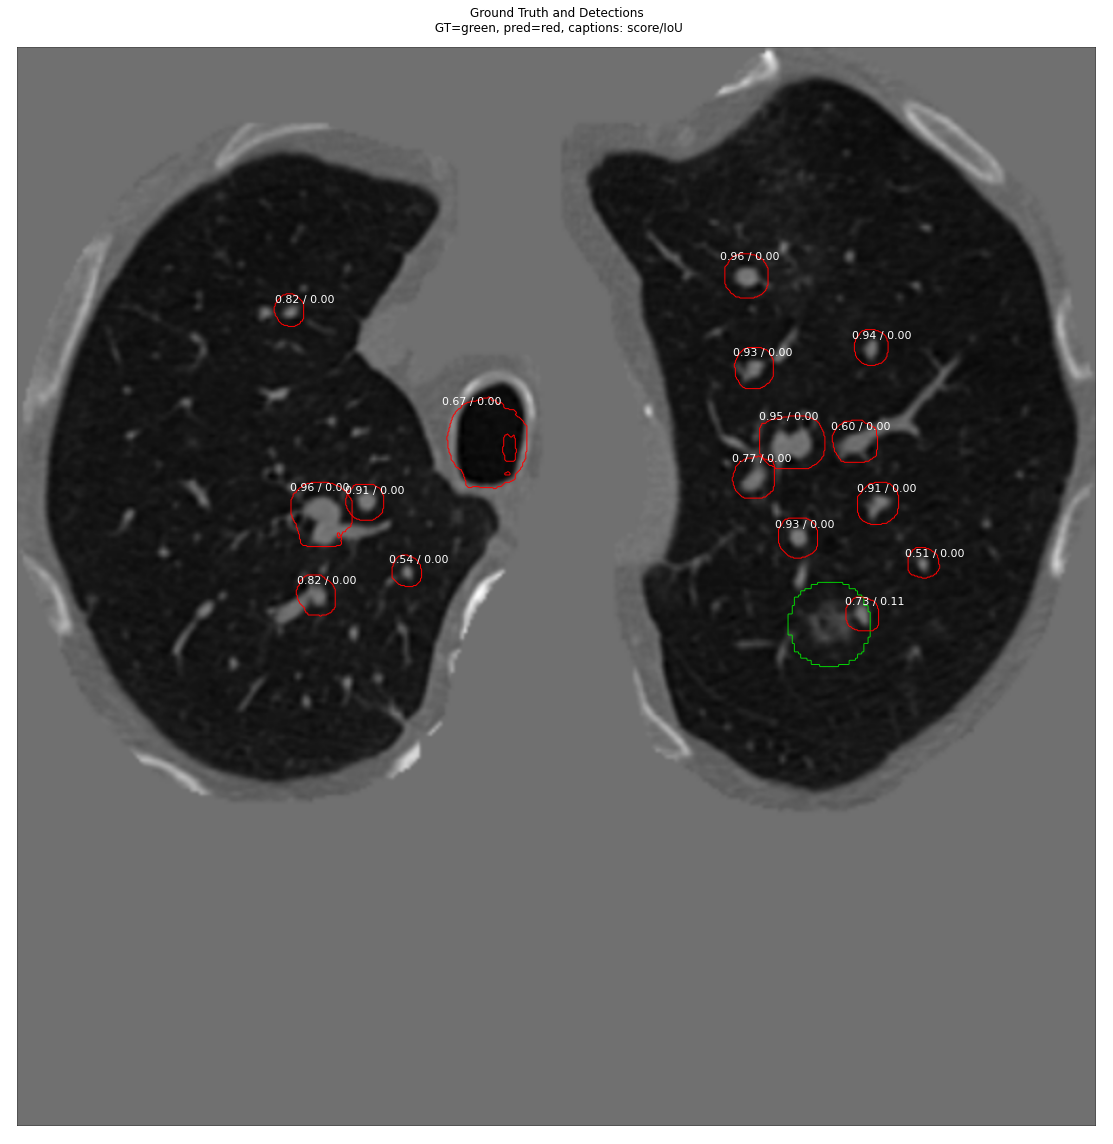

In [ ]:
image_id = random.choice(dataset.image_ids)
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)
#print(gt_mask.shape,r['masks'].shape)
#import cv2
#cv2.imwrite("Mask.png", gt_mask*255.0) 
#cv2.imwrite(filename, img) 
from sklearn.metrics import mean_squared_error
print("Shapes ",gt_bbox.shape,r['rois'].shape)
#print(gt_bbox)
#print(r['rois'])

if gt_bbox.shape[0]>r['rois'].shape[0]:
    y_pred = np.zeros((gt_bbox.shape[0],4))
    y_pred[0:r['rois'].shape[0],:] = r['rois']
    y_true = gt_bbox
elif gt_bbox.shape[0]<r['rois'].shape[0]:
    y_true = np.zeros((r['rois'].shape[0],4))
    y_true[0:gt_bbox.shape[0],:] = gt_bbox
    y_pred = r['rois']
else:
    y_pred = r['rois']
    y_true = gt_bbox
print(y_true.shape,y_pred.shape)   
print(mean_squared_error(y_true,y_pred))

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)


In [ ]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import parse_args

args = parse_args.parse_args()

import dataset
import training


MODEL_DIR = os.path.join(ROOT_DIR, "logs")

weight_path = args.weight

config = training.CustomConfig()
dataset_dir = os.path.join(ROOT_DIR, args.dataset)
image_path = os.path.join(ROOT_DIR, args.image)

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
#DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0


# Load validation dataset
dataset = dataset.CustomDataset()
dataset.load_custom(dataset_dir, "val")

dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)


print("Loading weights ", weight_path)
model.load_weights(weight_path, by_name=True)


n = 0
positive = 0
negative = 0


for image_name in sorted(os.listdir(image_path)):
  if image_name.endswith(('.jpg','.jpeg')):
    image = skimage.io.imread(os.path.join(image_path, image_name))
    if image.ndim != 3:
      image = skimage.color.gray2rgb(image)
    if image.shape[-1] == 4:
      image = image[..., :3]
    check = 0
    
    results = model.detect([image], verbose=1)
    r = results[0]
    n += 1

    if r["rois"].shape[0]:
      positive += 1
      check = 1
    else: negative += 1

    if check:
      print(image_name," - Positive")
    else: print(image_name," - Negative")

    # visualize.display_instances(image_name,image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])
    visualize.save_image(image_name, image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

print("Total: ", n ," images")
print("Postivie: ", positive, " - ",positive/n * 100,"%")
print("Negative: ", negative, " - ",negative/n * 100,"%")


You are using pip version 19.0.3, however version 22.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.